**Assignment 3: Reverse engineering predator prey system**

Esther Bakels, Loes Bijman, Sacha Gijsbers

Import data and recreate plot

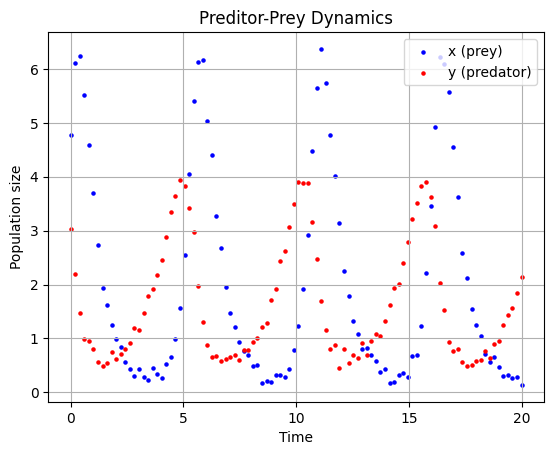

In [87]:
import pandas as pd
import matplotlib.pyplot as plt

# import data from csv
df = pd.read_csv("predator-prey-data.csv", delimiter = ",")
t = df["t"]
x = df["x"]
y = df["y"]

# split data for two y axises
plt.title("Preditor-Prey Dynamics")
plt.ylabel("Population size")
plt.xlabel("Time")
plt.grid()
plt.scatter(t, x, color = 'b', s = 5, label = 'x (prey)')
plt.scatter(t, y, color = 'r', s = 5, label = 'y (predator)')
plt.legend()
t_data = []
for i in range(0, 21, 5):
    t_data.append(i)
plt.xticks(t_data)

# show plot
plt.show()

In [39]:
print(f"Initial amount of prey: {df['x'][0]}")
print(f"Initial amount of predators: {df['y'][0]}")

Initial amount of prey: 4.78163509155479
Initial amount of predators: 3.03525735602479


Implement the system of ODEs

In [146]:
from scipy.integrate import odeint
import numpy as np

def lotka_volterra(init, t, alpha, beta, delta, gamma):
    x, y = init
    dxdt = alpha * x - beta * x * y 
    dydt = delta * x * y - gamma * y
    return [dxdt, dydt]


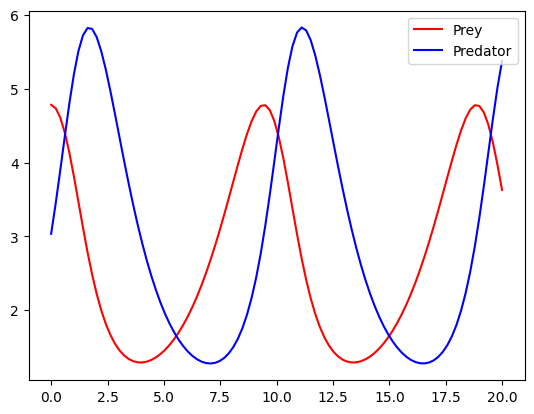

In [99]:
# take initial conditions from data set
x0 = 4.78163509155479
y0 = 3.03525735602479

init = [x0,y0]

alpha = 0.6
beta = 0.2
delta = 0.3
gamma = 0.8

t = np.linspace(0,20,100)

out = odeint(lotka_volterra, init, t, args = (alpha,beta,delta,gamma))

x, y = out.T[0], out.T[1]

plt.plot(t, x, label = 'Prey', color = 'r')
plt.plot(t, y, label = 'Predator', color = 'b')
plt.legend()
plt.show()

In [42]:
# label the data and turn to array
data = np.concatenate((np.array(df['x']),np.array(df['y'])))

In [43]:
from scipy.optimize import minimize

def abs_residual(init, t, alpha, beta, delta, gamma):
    out = odeint(lotka_volterra, init, t, args = (alpha,beta,delta,gamma))
    return np.linalg.norm(out - data)**2

In [175]:
def loss_function_res(params, t_data, x, y,):
    y0 = [x[0], y[0]]
    t = np.linspace(t_data[0], t_data[-1], num=len(t_data))
    output = odeint(lotka_volterra, y0, t, args=(params[0], params[1], params[2], params[3]))

    loss = 0
    for i in range(len(t)):
        x_data = x[i]
        x_model = output[i,0]

        y_data = y[i]
        y_model = output[i,1]

        res = (x_data - x_model)**2 + (y_data - y_model)**2
        loss += res
    return loss

In [176]:
def loss_function_norm(params, t_data, x, y,):
    y0 = [x[0], y[0]]
    t = np.linspace(t_data[0], t_data[-1], num=len(t_data))
    output = odeint(lotka_volterra, y0, t, args=(params[0], params[1], params[2], params[3]))

    return (np.linalg.norm(x - output[:,0]))**2 + (np.linalg.norm(y - output[:,1]))**2

[3.72640684 1.46640186 0.15321759 0.3521164 ]
[3.50675038 1.44899208 0.16027167 0.3749169 ]


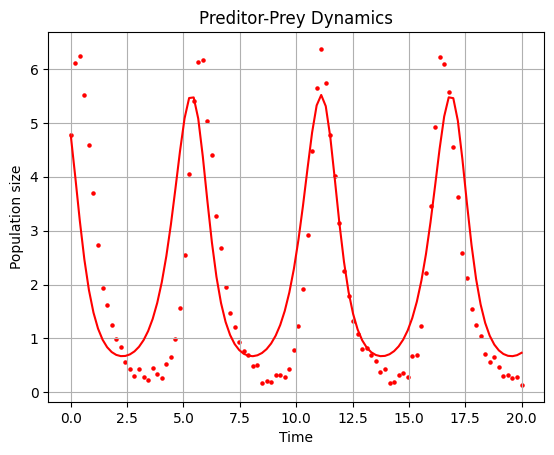

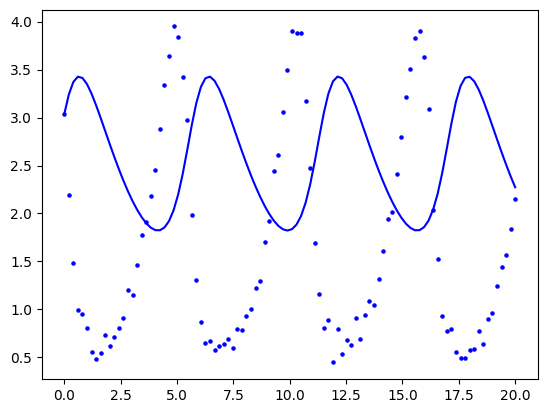

In [177]:
from scipy.optimize import minimize
params0 = np.array([1,1,1,1])
t = np.array(df['t'], dtype=float)
x = np.array(df['x'], dtype=float)
y = np.array(df['y'], dtype=float)
minimum_res = minimize(loss_function_res, params0, args=(t,x,y)).x
print(minimum_res)

minimum_norm = minimize(loss_function_norm, params0, args=(t,x,y)).x
print(minimum_norm)

alpha_fit = minimum_res[0]
beta_fit = minimum_res[1]
delta_fit = minimum_res[2]
gamma_fit = minimum_res[3]

y0 = [x[0], y[0]]
t = np.linspace(t[0], t[-1], num=len(t))

output = odeint(lotka_volterra, y0, t, args=(alpha_fit, beta_fit, delta_fit, gamma_fit))

plt.title("Preditor-Prey Dynamics")
plt.ylabel("Population size")
plt.xlabel("Time")
plt.grid()

plt.plot(t,output[:,0], color="r")
plt.scatter(df["t"], df["x"], color = 'r', s = 5, label = 'x (prey)')

plt.show()

plt.plot(t,output[:,1], color="b")
plt.scatter(df["t"], df["y"], color = 'b', s = 5, label = 'y (predator)')

plt.show()

params:  [0.21604835 0.01023808 1.87117758 4.1845177 ]
params:  [2.43304449 1.29898331 0.00500026 0.17189469]


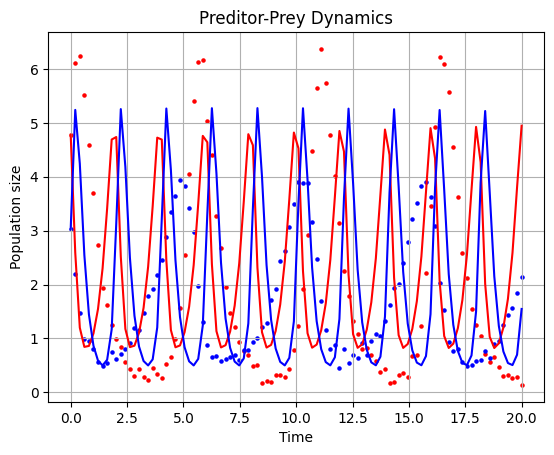

In [166]:
from scipy.optimize import curve_fit
y0 = [x[0], y[0]]
t = np.linspace(t[0], t[-1], num=len(t))

params0 = np.array([0.5,0.8,0.3,0.5])
t = np.array(df['t'], dtype=float)
x = np.array(df['x'], dtype=float)
y = np.array(df['y'], dtype=float)

def ode_0(t, alpha_fit, beta_fit, delta_fit, gamma_fit):
    return odeint(lotka_volterra, y0, t, args=(alpha_fit, beta_fit, delta_fit, gamma_fit))[:,0]

params_0= curve_fit(ode_0, t, x)[0]
print("params: ", params_0)

def ode_1(t, alpha_fit, beta_fit, delta_fit, gamma_fit):
    return odeint(lotka_volterra, y0, t, args=(alpha_fit, beta_fit, delta_fit, gamma_fit))[:,1]

params_1 = curve_fit(ode_1, t, x)[0]
print("params: ", params_1)

alpha_fit = (params_0[0] + params_1[0])
beta_fit = (params_0[1] + params_1[1])
delta_fit = (params_0[2] + params_1[2])
gamma_fit = (params_0[3] + params_1[3])

# alpha_fit, beta_fit, delta_fit, gamma_fit = params
# fitted_curve = odeint(lotka_volterra, y0, t, args=(alpha_fit, beta_fit, delta_fit, gamma_fit))

output = odeint(lotka_volterra, y0, t, args=(alpha_fit, beta_fit, delta_fit, gamma_fit))

plt.title("Preditor-Prey Dynamics")
plt.ylabel("Population size")
plt.xlabel("Time")
plt.grid()

plt.plot(t,output[:,0], color="r")
plt.scatter(df["t"], df["x"], color = 'r', s = 5, label = 'x (prey)')

# plt.show()

plt.plot(t,output[:,1], color="b")
plt.scatter(df["t"], df["y"], color = 'b', s = 5, label = 'y (predator)')

plt.show()